In [2]:
import json
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors

In [3]:
model_fasttext = KeyedVectors.load("cc.ko.300.kv")
model_custom = KeyedVectors.load("wiktionary5800_custom.kv")

In [4]:
with open("korean_frequency.json", encoding="utf-8") as f:
    data = json.load(f)

word_list = sorted({w for group in data.values() for w in group})
word_list_fasttext = [w for w in word_list if w in model_fasttext]
word_list_custom = [w for w in word_list if w in model_custom]

In [5]:
sampled_answers = [
    '넉넉하다', '익히다', '녹색', '운전자', '오랫동안',
    '소프트웨어', '광고', '찾아오다', '흥분하다', '도심',
    '이제야', '끊다', '실정', '월급', '발견',
    '기운', '교육', '빌다', '신선하다', '끝나다',
    '이야기', '기록', '그릇', '대답', '출근'
]

In [6]:
# 후보 필터링
def update_candidates(model, candidates, guess, similarity, tolerance=5.0):
    return [
        cand for cand in candidates
        if cand in model and guess in model and abs(model.similarity(cand, guess) * 100 - similarity) <= tolerance
    ]

# 최적 추측어 선택
def select_best_guess(model, candidates, tried):
    max_entropy = -1
    best_word = None
    for word in candidates:
        if word not in model:
            continue
        sims = [model.similarity(word, other) for other in tried if other in model]
        entropy = -np.sum(np.log(np.clip(sims, 1e-5, 1))) if sims else 0
        if entropy > max_entropy:
            max_entropy = entropy
            best_word = word
    return best_word or random.choice(candidates)

# 게임 시뮬레이션
def simulate_game(model, word_list, answer, max_steps=100):
    candidates = word_list.copy()
    tried = []
    for _ in range(1, max_steps + 1):
        guess = select_best_guess(model, candidates, tried)
        tried.append(guess)
        if guess == answer:
            return tried
        similarity = model.similarity(guess, answer) * 100
        candidates = update_candidates(model, candidates, guess, similarity)
    return tried

# 모델 평가 함수
def evaluate_model(model, word_list, label):
    results = []
    for ans in sampled_answers:
        if ans not in model:
            continue
        tried = simulate_game(model, word_list, ans)
        results.append({
            'model': label,
            'answer': ans,
            'steps': len(tried),
            'success': (tried[-1] == ans)
        })
    return pd.DataFrame(results)

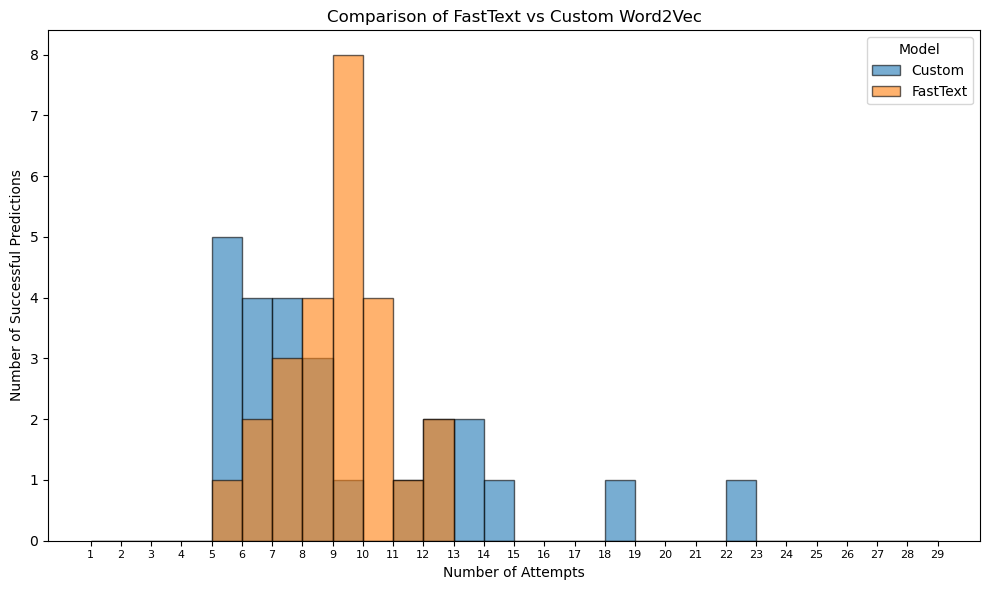

📊 평균 시도 횟수:
 model
Custom      9.00
FastText    8.68
Name: steps, dtype: float64

✅ 성공률 (%):
 model
Custom      100.0
FastText    100.0
Name: success, dtype: float64


In [ ]:
# 평가 실행
df_fasttext = evaluate_model(model_fasttext, word_list_fasttext, "FastText")
df_custom = evaluate_model(model_custom, word_list_custom, "Custom")
df_combined = pd.concat([df_fasttext, df_custom], ignore_index=True)

# 결과 시각화
plt.figure(figsize=(10, 6))
for label, group in df_combined[df_combined['success']].groupby('model'):
    plt.hist(group['steps'], bins=range(1, 30), alpha=0.6, label=label, edgecolor='black')
plt.xticks(np.arange(1, 30, 1), fontsize=8)
plt.xlabel("Number of Attempts")
plt.ylabel("Number of Successful Predictions")
plt.title("Comparison of FastText vs Custom Word2Vec")
plt.legend(title="Model")
plt.tight_layout()
plt.show()

# 평균 결과 출력
avg_steps = df_combined.groupby("model")["steps"].mean()
success_rate = df_combined.groupby("model")["success"].mean() * 100
print("평균 시도 횟수:\n", avg_steps.round(2))
print("\n성공률 (%):\n", success_rate.round(1))